In [1]:
# Import libraries and set colors for plotting
import sys
import ete3
import os
import random
from os import walk
sys.path.insert(0,'../scripts/')
from classDeclarationsAndFunctions import RootedTree
from fileIO import ReadRootedTree
from MarkovModels import GenerateQForStationaryDistribution, Get11FreeRates
from math import floor, ceil
from config import projectPath
import matplotlib.pyplot as plt
import numpy as np
from math import log

data_path = projectPath + "data/"
figures_path = projectPath + "figures/"
results_path = projectPath + "results/"

seqlen_list = [1000,2000,5000,10000]
# method_list = ['fasttree','iqtree','mstbackbone','raxmlng']
method_list = ['mstbackbone','fasttree','raxmlng','iqtree']
method_colors_map = {}
method_colors_map['mstbackbone'] = ['darkblue']
method_colors_map['fasttree'] = ['black']
method_colors_map['raxmlng'] = ['fuchsia']
method_colors_map['iqtree'] = ['darkorange']
method_colors_map['mst'] = ['cyan']


def Check_results_file_names(method,exp_id):
    exp_dir = data_path + "grove_exp/" + exp_id
    sequence_file_name = exp_dir + "/sequences_" + exp_id + ".fas"
    if method == "raxmlng":
        log_file_name = projectPath + 'batch_scripts/RAxMLNG_' + exp_id + '.raxml.log'
        tree_file_name = projectPath + 'batch_scripts/RAxMLNG_' + exp_id + '.raxml.bestTree'
    elif method.startswith("mstbackbone"):        
        log_file_name = data_path + 'grove_exp/' + exp_id + '/' + exp_id + '.mstbackbone_log'
        tree_file_name = data_path + 'grove_exp/' + exp_id + '/' + exp_id + '.newick'
    elif method == "fasttree":
        log_file_name = data_path + 'grove_exp/' + exp_id + '/sequences_' + exp_id + '.fas.fasttree_errlog'
        tree_file_name = data_path + 'grove_exp/' + exp_id + '/sequences_' + exp_id + '.fas.fasttree_newick'
    elif method == "iqtree":
        log_file_name = data_path + 'grove_exp/' + exp_id + '/sequences_' + exp_id + '.fas_iqtree2.0.log'
        tree_file_name = data_path + 'grove_exp/' + exp_id + '/sequences_' + exp_id + '.fas_iqtree2.0.treefile'        
    if os.path.exists(log_file_name) and os.path.exists(tree_file_name):
        if os.path.getsize(log_file_name) > 0 and os.path.getsize(tree_file_name) > 0:
            if method == "iqtree":
                log_file = open(log_file_name,"r")
                for line in log_file:
                    if line.startswith("ERROR: *** IQ-TREE CRASHES WITH SIGNAL ABORTED"):
                        print("IQ-TREE crashes for ", exp_id)
                        return (False)
                log_file.close()
                return (True)
            else:
                return(True)
        else:
            return(False)
    else:
        return(False)

In [4]:
# Store grove trees
import subprocess as sub
simulated_data_path = data_path + "simulated_data/RAxMLGrove_selected/"
raxml_grove_path = data_path + "RAxMLGrove/trees/"
tree_id_num_leaves_scalability_file = open(data_path + "selected_grove_tree_ids_scalability","r")
for line in tree_id_num_leaves_scalability_file:
    tree_id = line.split(",")[0]
    tree_file_dir = raxml_grove_path + tree_id + "/"
    sub.call("cp -r " + tree_file_dir + "\t" + simulated_data_path, shell = True)
    print(tree_id)



12258
11413
13668
19588
12132
15813
29800
10610
11500
13912
10672
18667
21578
36872
10959
17361
2658
3455
58567
19605
240
26326
31013
17875
15197
1077
12538
17533
25688
37876
24966
30123
47824
52785
2098
13643
15041
30314
3929
6759
19914
22881
23795
25059
29793
37875
17179
11617
58903
59221
18879
37109
3014
15331
28879
29534
38987
55431
57576
13150
45558
46863
17294
36750
34633
190
16607
19996
21647
21642
33082
55906
15712
1851
26944
6770
37906
54795
23159
15718
42707
28950
38104
21357
54997
33945
15523
15574
11839
12509
57913
3277
36617
14234
22612
53266
12396
39604
20479
44590
36591
15786
35331
17160
23286
28619
404
10022
10894
55379
24986
53458
14206
15551
21337


In [ ]:
# Job scripts
data_path = projectPath + "data/"
tools_path_geniux = "/project/exaptation/Tools/"
num_trees_simulated = 0
for seq_len in [1000,2000,5000,10000]:
    iqtree_script = open("../batch_scripts/iqtree_scalability_"+str(seq_len)+".sh","w")
    mstbackbone_script = open("../batch_scripts/mstbackbone_scalability_"+str(seq_len)+".sh","w")
    fasttree_script = open("../batch_scripts/fastree_scalability_"+str(seq_len)+".sh","w")
    raxml_script = open("../batch_scripts/raxml_scalability_"+str(seq_len)+".sh","w")
    tree_id_num_leaves_scalability_file = open("../data/selected_grove_tree_ids_scalability","r")
    for line in tree_id_num_leaves_scalability_file:
        tree_id = line.strip().split(',')[0].strip()
        num_leaves = int(line.strip().split(',')[1].strip())
        num_trees_simulated += 1
        print("Writing batch commands for tree ", str(num_trees_simulated))
        mxqsub_prefix = ""
        exp_id = "treeId_"+tree_id+"_numLeaves_"+str(num_leaves)+"_seqLen_"+str(seq_len)
        exp_dir = data_path + "grove_exp/" + exp_id
        sequence_file_name = exp_dir + "/sequences_"+exp_id+".fas"
        ###############        IQ-TREE      ##################
        # mxqsub_prefix = "mxqsub -t 2d -m 10G -n -N iqtree_scale\t"
        # mxqsub_prefix += " --stderr=err_iqtree_scalability_"+exp_id
        # mxqsub_prefix += " --stdout=out_iqtree_scalability_"+exp_id
        iqtree_command = tools_path_geniux + "iqtree2"
        iqtree_command += ' -s ' + sequence_file_name + ' -st DNA'
        iqtree_command += ' -nt ' + str(1)
        iqtree_command += ' -seed 1234'
        # iqtreeCommand += ' -quiet'
        iqtree_command += ' -redo'
        iqtree_command += ' -pre ' + sequence_file_name + "_iqtree2.0"
        iqtree_command += ' -m 12.12+FO'
        iqtree_script.write(mxqsub_prefix + iqtree_command + "\n")
        ###############     MST-BACKBONE     ###################
        # mst_backbone_command
        # mxqsub_prefix = "mxqsub -t 2d -m 10G -n -N mstbackbone_scale\t"
        # mxqsub_prefix += " --stderr=err_mstbackbone_scalability_" + exp_id
        # mxqsub_prefix += " --stdout=out_mstbackbone_scalability_" + exp_id
        mst_backbone_command = tools_path_geniux + "mst-backbone"
        mst_backbone_command += '\t--seq ' + sequence_file_name
        mst_backbone_command += '\t--out ' + exp_id
        mstbackbone_script.write(mxqsub_prefix + mst_backbone_command + "\n")
        ###############        RAxML-NG       ##################
        # mxqsub_prefix = "mxqsub -t 2d -m 10G -n -N raxmlng_scale\t"
        # mxqsub_prefix += " --stderr=err_raxmlng_scalability_" + exp_id
        # mxqsub_prefix += " --stdout=out_raxmlng_scalability_" + exp_id
        raxml_command = tools_path_geniux + "raxml-ng"
        fileNamePrefix = 'RAxMLNG_' + exp_id
        raxml_command += ' --tree pars{1}'
        raxml_command += ' --model GTR --msa ' + sequence_file_name
        raxml_command += ' --threads 1'
        # raxml_command += ' --redo '
        raxml_command += ' --tip-inner on --pat-comp on --site-repeats on'
        raxml_command += ' --prefix ' + fileNamePrefix
        raxml_script.write(mxqsub_prefix + raxml_command + "\n")
        #############          FastTree        ################
        # mxqsub_prefix = ""
        # mxqsub_prefix = "mxqsub -t 2d -m 1G -n -N fasttree_scale\t"
        # mxqsub_prefix += " --stderr=err_fasttree_scalability_"+exp_id
        # mxqsub_prefix += " --stdout=out_fasttree_scalability_"+exp_id
        output_tree_file_name = sequence_file_name + '.fasttree_newick'
        std_err_file_name = sequence_file_name + '.fasttree_errlog'
        fasttree_command = tools_path_geniux + 'FastTree'
        fasttree_command += ' -nt -nosupport -nocat -gtr < '+ sequence_file_name
        fasttree_command += ' > ' + output_tree_file_name
        fasttree_command += ' 2> ' + std_err_file_name
        fasttree_script.write(mxqsub_prefix + fasttree_command + "\n")
        ########################################################
    tree_id_num_leaves_scalability_file.close()
    raxml_script.close()
    fasttree_script.close()
    mstbackbone_script.close()
    iqtree_script.close()

In [12]:
# Count num of results
run_time_num_taxa = {}
run_time_seq_length = {}
tools_path_geniux = "/project/exaptation/Tools/"
method_list = ['fasttree','iqtree','mstbackbone','raxmlng']
seqlen_list = [1000,2000,5000,10000]


num_results = {}
for method in method_list:
    num_results[method] = 0


num_trees_checked = 0
tree_id_num_leaves_scalability_file = open(data_path + "selected_grove_tree_ids_scalability","r")
for line in tree_id_num_leaves_scalability_file:
    tree_id = line.strip().split(',')[0].strip()
    num_leaves = int(line.strip().split(',')[1].strip())    
    for seq_len in seqlen_list:
        for method in method_list:
            exp_id = "treeId_" + tree_id + "_numLeaves_" + str(num_leaves) + "_seqLen_" + str(seq_len)
            if exp_id == "treeId_13643_numLeaves_1861_seqLen_1000" and method == "iqtree":
                print (method, exp_id)                
            if Check_results_file_names(method,exp_id):
                num_results[method] += 1
    num_trees_checked += 1
    print("Checked ",num_trees_checked," trees")

    
tree_id_num_leaves_scalability_file.close()

for method in method_list:
    print (num_results[method], "results available for ", method)

Checked  1  trees
Checked  2  trees
Checked  3  trees
Checked  4  trees


KeyboardInterrupt: 

In [5]:
# Scripts for unfinished jobs
# log_file_name = projectPath + '/batch_scripts/' + exp_id + '.mstbackbone_log'= False
create_scripts = True
method = "mst"
if create_scripts:
    data_path = projectPath + "data/"
    data_path_geniux = "/project/exaptation/Projects/MSTBasedForests/data/"
    tools_path_geniux = "/project/exaptation/Tools/"
    max_num_jobs = 1
    num_jobs = 0
    script_ind = 1 
    method_script =  open(projectPath + "batch_scripts/"+method+"_unfinished_"+str(script_ind)+".sh","w")
    # mstbackbone_script = open(projectPath + "batch_scripts/mstbackbone_unfinished_"+str(script_ind)+".sh","w")
    mxqsub_prefix = ""
    tree_id_num_leaves_scalability_file = open(data_path + "selected_grove_tree_ids_scalability","r")
    tree_id_num_leaves_list = []
    for line in tree_id_num_leaves_scalability_file:
        tree_id_num_leaves_list.append(line)
    tree_id_num_leaves_scalability_file.close()
    random.shuffle(tree_id_num_leaves_list)

    for line in tree_id_num_leaves_list:
        tree_id = line.strip().split(',')[0].strip()
        num_leaves = int(line.strip().split(',')[1].strip())
        # num_trees_simulated += 1
        for seq_len in seqlen_list:
            # for method in method_list:            
            exp_id = "treeId_" + tree_id + "_numLeaves_" + str(num_leaves) + "_seqLen_" + str(seq_len)
            exp_dir = data_path_geniux + "grove_exp/" + exp_id
            sequence_file_name = exp_dir + "/sequences_" + exp_id + ".fas"
            if not Check_results_file_names(method,exp_id):
                if num_jobs >= max_num_jobs:
                    num_jobs = 0
                    # mstbackbone_script.close()
                    method_script.close()
                    script_ind += 1
                    print("Creating unfinished script file with index",script_ind)
                    method_script = open(projectPath + "batch_scripts/"+method+"_unfinished_"+str(script_ind)+".sh","w")
                if method == "mstbackbone":
                    mst_backbone_command = tools_path_geniux + "mst-backbone"
                    mst_backbone_command += '\t--seq ' + sequence_file_name
                    mst_backbone_command += '\t--out ' + exp_id
                    method_script.write(mxqsub_prefix + mst_backbone_command + "\n")
                elif method == "iqtree":
                    iqtree_command = tools_path_geniux + "iqtree2"
                    iqtree_command += ' -s ' + sequence_file_name + ' -st DNA'
                    iqtree_command += ' -nt ' + str(1)
                    iqtree_command += ' -seed 1234'
                    # iqtreeCommand += ' -quiet'
                    iqtree_command += ' -redo'
                    iqtree_command += ' -pre ' + sequence_file_name + "_iqtree2.0"
                    iqtree_command += ' -m 12.12+FO'
                    method_script.write(mxqsub_prefix + iqtree_command + "\n")
                elif method == "raxmlng":
                    raxml_command = tools_path_geniux + "raxml-ng"
                    fileNamePrefix = 'RAxMLNG_' + exp_id
                    raxml_command += ' --tree pars{1}'
                    raxml_command += ' --model GTR --msa ' + sequence_file_name
                    raxml_command += ' --threads 1'
                    # raxml_command += ' --redo '
                    raxml_command += ' --tip-inner on --pat-comp on --site-repeats on'
                    raxml_command += ' --prefix ' + fileNamePrefix
                    method_script.write(mxqsub_prefix + raxml_command + "\n")
                num_jobs += 1
    print("Number of unfinished script files is",script_ind)
    method_script.close()
else:
    print("Scripts not created")


Creating unfinished script file with index 2
IQ-TREE crashes for  treeId_15712_numLeaves_2659_seqLen_10000
Creating unfinished script file with index 3
IQ-TREE crashes for  treeId_15523_numLeaves_3314_seqLen_2000
Creating unfinished script file with index 4
Number of unfinished script files is 4


In [5]:
# Store run times
method_list = ['fasttree','iqtree','mstbackbone','raxmlng']

def Get_run_time(method,exp_id):
    # print(method, exp_id)
    runTime = -1
    if method == "raxmlng":
        log_file_name = projectPath + '/batch_scripts/RAxMLNG_' + exp_id + '.raxml.log'
        log_file = open(log_file_name,"r")
        for line in log_file:
            if line.startswith('Elapsed time:'):
                runTime = float(line.strip().split('Elapsed time:')[1].split(' seconds')[0])
    elif method == "mstbackbone":
        log_file_name = data_path + 'grove_exp/' + exp_id + '/' + exp_id + '.mstbackbone_log'
        log_file = open(log_file_name,"r")
        for line in log_file:
            if line.startswith('Total CPU time used is '):
                runTime = float(line.split('Total CPU time used is ')[1].split(' second(s)')[0])    
    elif method == "fasttree":
        log_file_name = data_path + 'grove_exp/' + exp_id + '/sequences_' + exp_id + '.fas.fasttree_errlog'
        log_file = open(log_file_name,"r")
        for line in log_file:
            if line.startswith('Total time: '):
                runTime = float(line.strip().split('Total time: ')[1].split(' seconds')[0])
    elif method == "iqtree":
        log_file_name = data_path + 'grove_exp/' + exp_id + '/sequences_' + exp_id + '.fas_iqtree2.0.log'
        log_file = open(log_file_name,"r")
        for line in log_file:
            if line.startswith('Total CPU time used:'):
                runTime = float(line.split('Total CPU time used: ')[1].split(' sec')[0])                
    log_file.close()
    return (runTime)

def Get_dupl_seq(method,exp_id):    
    dupl_seq = 0
    log_file_name = projectPath + '/batch_scripts/RAxMLNG_' + exp_id + '.raxml.log'
    log_file = open(log_file_name,"r")
    for line in log_file:
        if line.startswith('WARNING: Duplicate sequences found:'):
            dupl_seq = int(line.strip().split('WARNING: Duplicate sequences found:')[1].strip())
    return (dupl_seq)

run_times_seq_len_method = {}
num_leaves_seq_len_method = {}
tree_id_seq_len_method = {}
dupl_seq_seq_len_method = {}
for seq_len in seqlen_list:
    run_times_seq_len_method[seq_len] = {}
    num_leaves_seq_len_method[seq_len] = {}
    tree_id_seq_len_method[seq_len] = {}
    dupl_seq_seq_len_method[seq_len] = {}
    for method in method_list: 
        run_times_seq_len_method[seq_len][method] = []
        num_leaves_seq_len_method[seq_len][method] = []        
        tree_id_seq_len_method[seq_len][method] = []
        dupl_seq_seq_len_method[seq_len][method] = []


method_list = ['fasttree','iqtree','mstbackbone','raxmlng']
num_leaves_list = []
seqlen_list = [1000,2000,5000,10000]
results_path = projectPath + "results/"
run_time_grove_file = open(results_path + "run_time_grove","w")
run_time_grove_file.write('run_time, seq_len, num_leaves, method, tree_id, dupl_seq\n')

tree_id_num_leaves_scalability_file = open(data_path + "selected_grove_tree_ids_scalability","r")
for line in tree_id_num_leaves_scalability_file:
    tree_id = line.strip().split(',')[0].strip()
    num_leaves = int(line.strip().split(',')[1].strip())
    for seq_len in seqlen_list:
        for method in method_list:
            exp_id = "treeId_" + tree_id + "_numLeaves_" + str(num_leaves) + "_seqLen_" + str(seq_len)
            if Check_results_file_names(method,exp_id):
                run_time = Get_run_time(method,exp_id)
                dupl_seq = Get_dupl_seq(method,exp_id)
                if (run_time > 0) :
                    run_times_seq_len_method[seq_len][method].append(run_time)
                    num_leaves_seq_len_method[seq_len][method].append(num_leaves)
                    tree_id_seq_len_method[seq_len][method].append(tree_id)
                    dupl_seq_seq_len_method[seq_len][method].append(dupl_seq)
                    run_time_grove_file.write(str(run_time) + ", " + str(seq_len) + "," + str(num_leaves) + ", " + method + ", " + str(tree_id) + ", " + str(dupl_seq) + "\n")

tree_id_num_leaves_scalability_file.close()
run_time_grove_file.close()


KeyboardInterrupt: 

In [3]:
# Read runtime
run_times_seq_len_method = {}
num_leaves_seq_len_method = {}
tree_id_seq_len_method = {}
dupl_seq_seq_len_method = {}
for seq_len in seqlen_list:
    run_times_seq_len_method[seq_len] = {}
    num_leaves_seq_len_method[seq_len] = {}
    tree_id_seq_len_method[seq_len] = {}
    dupl_seq_seq_len_method[seq_len] = {}
    for method in method_list: 
        run_times_seq_len_method[seq_len][method] = []
        num_leaves_seq_len_method[seq_len][method] = []        
        tree_id_seq_len_method[seq_len][method] = []
        dupl_seq_seq_len_method[seq_len][method] = []


run_time_grove_file = open(results_path + "run_time_grove","r")
run_time_grove_file.readline()
for res in run_time_grove_file:
    run_time, seq_len, num_leaves, method, tree_id, dupl_seq = res.split(",")
    run_time = float(run_time.strip())
    seq_len = int(seq_len.strip())
    tree_id = tree_id.strip()
    method = method.strip()
    num_leaves = int(num_leaves.strip())
    dupl_seq = int(dupl_seq.strip())
    run_times_seq_len_method[seq_len][method].append(run_time)
    num_leaves_seq_len_method[seq_len][method].append(num_leaves)
    tree_id_seq_len_method[seq_len][method].append(tree_id)
    dupl_seq_seq_len_method[seq_len][method].append(dupl_seq)
run_time_grove_file.close()

In [10]:
mstbackbone_max_run_time_id = run_times_seq_len_method[1000]["mstbackbone"].index(max(run_times_seq_len_method[1000]["mstbackbone"]))
mstbackbone_min_run_time_id = run_times_seq_len_method[1000]["mstbackbone"].index(min(run_times_seq_len_method[1000]["mstbackbone"]))
print ("max")
tree_id = tree_id_seq_len_method[1000]["mstbackbone"][mstbackbone_max_run_time_id]
print(tree_id)
print("num_leaves_is", num_leaves_seq_len_method[1000]["mstbackbone"][mstbackbone_max_run_time_id])
print("run_times_is", run_times_seq_len_method[1000]["mstbackbone"][mstbackbone_max_run_time_id])
print ("min")
tree_id = tree_id_seq_len_method[1000]["mstbackbone"][mstbackbone_min_run_time_id]
print(tree_id)
print("num_leaves_is", num_leaves_seq_len_method[1000]["mstbackbone"][mstbackbone_min_run_time_id])
print("run_times_is", run_times_seq_len_method[1000]["mstbackbone"][mstbackbone_min_run_time_id])

max
10022
num_leaves_is 4307
run_times_is 571334.0
min
10610
num_leaves_is 1131
run_times_is 283.0


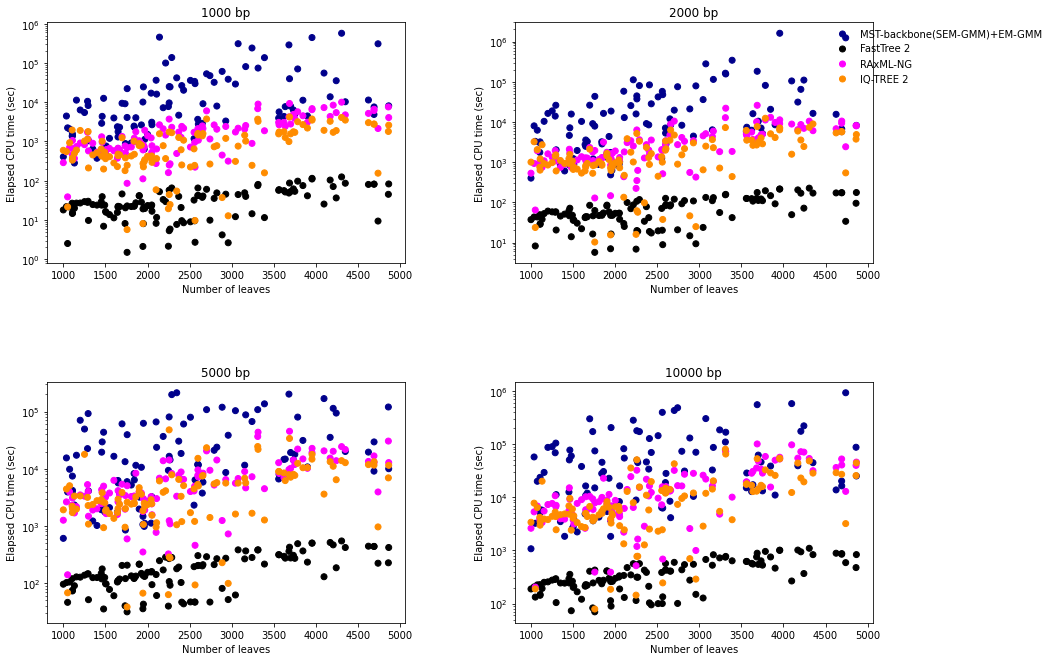

In [4]:
# Plot run times for all methods

import matplotlib
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from matplotlib.rcsetup import cycler
# cmap = ListedColormap(["darkblue","black","fuchsia","orange"])
# plt.rcParams['axes.prop_cycle'] = plt.cycler('color', cmap)
# plt.style.use('tableau-colorblind10')
import numpy as np
from math import log

# Fixing random state for reproducibility

fig, ax = plt.subplots(2,2)
i = 0
seq_len = 2000

# method_list = ['fasttree', 'mstbackbone']
# method_list = ['raxmlng','iqtree','fasttree','mstbackbone']
method_list = ['mstbackbone','fasttree','raxmlng','iqtree']
method_colors = {}
for method in method_list:
    method_colors[method] = {}
    for seq_len in seqlen_list:
        method_colors[method][seq_len] = method_colors_map[method] * len(num_leaves_seq_len_method[seq_len][method])
        # if method == 'fasttree':
        if seq_len == 1000:
            # ax_fast.subplot(2, 2, i)    
            ax[0, 0].scatter(num_leaves_seq_len_method[seq_len][method],run_times_seq_len_method[seq_len][method],label=method,c=method_colors[method][seq_len])
            ax[0, 0].set_title(str(seq_len) + " bp")
            ax[0, 0].set_xlabel("Number of leaves")
            ax[0, 0].set_ylabel("Elapsed CPU time (sec)")
            # ax[0, 0].set_xscale("log")
            ax[0, 0].set_yscale("log")
        # elif method == 'mstbackbone':
        elif seq_len == 2000:
            # ax_mstbackbone.subplot(2, 2, i)    
            ax[0, 1].scatter(num_leaves_seq_len_method[seq_len][method],run_times_seq_len_method[seq_len][method],label=method,c=method_colors[method][seq_len])            
            ax[0, 1].set_title(str(seq_len) + " bp")
            ax[0, 1].set_xlabel("Number of leaves")
            ax[0, 1].set_ylabel("Elapsed CPU time (sec)")
            # ax[0, 1].set_xscale("log")
            ax[0, 1].set_yscale("log")
        # elif method == 'raxmlng':
        elif seq_len == 5000:
            # ax_raxml.subplot(2, 2, i)    
            ax[1, 0].scatter(num_leaves_seq_len_method[seq_len][method],run_times_seq_len_method[seq_len][method],label=method,c=method_colors[method][seq_len])
            ax[1, 0].set_title(str(seq_len) + " bp")
            ax[1, 0].set_xlabel("Number of leaves")
            ax[1, 0].set_ylabel("Elapsed CPU time (sec)")
            # ax[1, 0].set_xscale("log")
            ax[1, 0].set_yscale("log")
        # elif method == 'iqtree':
        elif seq_len == 10000:
            # ax_iqtree.plot(2, 2, i) 
            ax[1, 1].scatter(num_leaves_seq_len_method[seq_len][method],run_times_seq_len_method[seq_len][method],label=method,c=method_colors[method][seq_len])
            ax[1, 1].set_title(str(seq_len) + " bp")
            ax[1, 1].set_xlabel("Number of leaves")
            ax[1, 1].set_ylabel("Elapsed CPU time (sec)")
            # ax[1, 1].set_xscale("log")
            ax[1, 1].set_yscale("log")
# ax.set_yscale("log")




fig.tight_layout(pad=0.04)
plt.legend(['MST-backbone(SEM-GMM)+EM-GMM','FastTree 2','RAxML-NG', 'IQ-TREE 2'], bbox_to_anchor=(1.5,2.2), loc ="lower right", frameon=False)
fig.set_size_inches(13, 10)
plt.savefig(figures_path+"grove_scalability.eps", dpi=100,bbox_inches='tight')
plt.savefig(figures_path+"grove_scalability.png", dpi=100,bbox_inches='tight')
# plt.show()
# plt.show()




log file exists


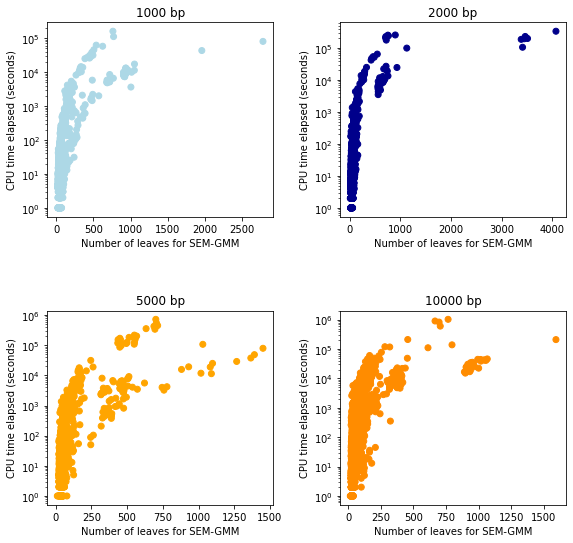

In [19]:
# Plot run times for structural EM

runtimes_sem_seq_len = {}
num_leaves_sem_seq_len = {}
tree_id_num_leaves_scalability_file = open(data_path + "selected_grove_tree_ids_scalability","r")
num_trees = 1
# print(seqlen_list)

for seq_len in seqlen_list:    
    runtimes_sem_seq_len[seq_len] = []
    num_leaves_sem_seq_len[seq_len] = []
    tree_id_num_leaves_scalability_file = open(data_path + "selected_grove_tree_ids_scalability","r")
    for line in tree_id_num_leaves_scalability_file:
        tree_id = line.strip().split(',')[0].strip()    
        num_leaves = int(line.strip().split(',')[1].strip())
        exp_id = "treeId_" + tree_id + "_numLeaves_" + str(num_leaves) + "_seqLen_" + str(seq_len)        
        log_file_name = data_path + 'grove_exp/' + exp_id + '/' + exp_id + '.mstbackbone_log'
        if os.path.exists(log_file_name):
            if os.path.getsize(log_file_name) > 0:
                if exp_id == "treeId_11839_numLeaves_3390_seqLen_5000":
                    print ("log file exists")
                log_file = open(log_file_name,"r")
                for log_line in log_file:
                    if log_line.startswith("CPU time used for computing subtree"):
                        try:                        
                            num_leaves_sem = log_line.split("CPU time used for computing subtree with")[1].split("leaves")[0].strip()
                            runtime_sem = log_line.split("leaves is")[1].split("seconds")[0].strip()
                            runtimes_sem_seq_len[seq_len].append(float(runtime_sem))
                            num_leaves_sem_seq_len[seq_len].append(int(num_leaves_sem))                            
                        except:
                            pass
                log_file.close()
    tree_id_num_leaves_scalability_file.close()
# print(num_leaves_sem_seq_len)
import matplotlib
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from matplotlib.rcsetup import cycler

import numpy as np
from math import log

# Fixing random state for reproducibility
# print (runtimes_sem_seq_len[5000])
fig, ax = plt.subplots(2,2)
i = 0
# seq_len = 2000

seqlen_colors_map = {}
seqlen_colors_map[1000] = ['lightblue']
seqlen_colors_map[2000] = ['darkblue']
seqlen_colors_map[5000] = ['orange']
seqlen_colors_map[10000] = ['darkorange']

# method_list = ['fasttree', 'mstbackbone']
# method_list = ['raxmlng','iqtree','fasttree','mstbackbone']
method_list = ['mstbackbone','fasttree','raxmlng','iqtree']
method_colors = {}
for seq_len in seqlen_list:
    seq_len_colors = seqlen_colors_map[seq_len] * len(runtimes_sem_seq_len[seq_len])
    if seq_len == 1000:
        ax[0,0].scatter(num_leaves_sem_seq_len[seq_len],runtimes_sem_seq_len[seq_len],c=seq_len_colors)
        ax[0,0].set_yscale("log")        
        ax[0,0].set_xlabel("Number of leaves for SEM-GMM")
        ax[0,0].set_ylabel("CPU time elapsed (seconds)")
        ax[0,0].set_title(str(seq_len)+ " bp")
    elif seq_len == 2000:
        ax[0,1].scatter(num_leaves_sem_seq_len[seq_len],runtimes_sem_seq_len[seq_len],c=seq_len_colors)
        ax[0,1].set_yscale("log")        
        ax[0,1].set_xlabel("Number of leaves for SEM-GMM")
        ax[0,1].set_ylabel("CPU time elapsed (seconds)")
        ax[0,1].set_title(str(seq_len)+ " bp")
    elif seq_len == 5000:
        ax[1,0].scatter(num_leaves_sem_seq_len[seq_len],runtimes_sem_seq_len[seq_len],c=seq_len_colors)
        ax[1,0].set_yscale("log")        
        ax[1,0].set_xlabel("Number of leaves for SEM-GMM")
        ax[1,0].set_ylabel("CPU time elapsed (seconds)")
        ax[1,0].set_title(str(seq_len)+ " bp")
    elif seq_len == 10000:
        ax[1,1].scatter(num_leaves_sem_seq_len[seq_len],runtimes_sem_seq_len[seq_len],c=seq_len_colors)
        ax[1,1].set_yscale("log")        
        ax[1,1].set_xlabel("Number of leaves for SEM-GMM")
        ax[1,1].set_ylabel("CPU time elapsed (seconds)")
        ax[1,1].set_title(str(seq_len)+ " bp")

fig.tight_layout(pad=-0.01)
fig.set_size_inches(8, 8)
plt.savefig(projectPath+"figures/grove_scalability_SEM_all.eps", dpi=100,bbox_inches='tight')
plt.savefig(projectPath+"figures/grove_scalability_SEM_all.png", dpi=100,bbox_inches='tight')

# fig, ax = plt.subplots(1,1)
# ax.scatter(num_leaves_sem_seq_len[seq_len],runtimes_sem_seq_len[seq_len],c=["darkblue"]*len(runtimes_sem_seq_len[seq_len]))
# ax.set_xscale("log")
# ax.set_yscale("log")
# ax.set_xlabel("Number of leaves for SEM-GM")
# ax.set_ylabel("CPU time elapsed (seconds)")
# ax.set_title("10000 bp")

# fig.tight_layout(pad=-0.01)
# fig.set_size_inches(5, 5)
# plt.savefig(projectPath+"figures/grove_scalability_SEM_seq_len_10000.eps", dpi=100,bbox_inches='tight')
# plt.savefig(projectPath+"figures/grove_scalability_SEM_seq_len_10000.png", dpi=100,bbox_inches='tight')


In [25]:
# correlation of run time vs num identical sequences
from scipy.stats import pearsonr
method = "mstbackbone"
for seq_len in seqlen_list:
    print ("Correlation for seq_len", seq_len," is ", pearsonr(dupl_seq_seq_len_method[seq_len][method], run_times_seq_len_method[seq_len][method]))


Correlation for seq_len 1000  is  (0.0917870786421926, 0.3447732084573777)
Correlation for seq_len 2000  is  (0.20204950737129296, 0.037798311722221575)
Correlation for seq_len 5000  is  (0.2678106749501678, 0.006238814394233491)
Correlation for seq_len 10000  is  (0.3476835945078235, 0.00034288553732254764)


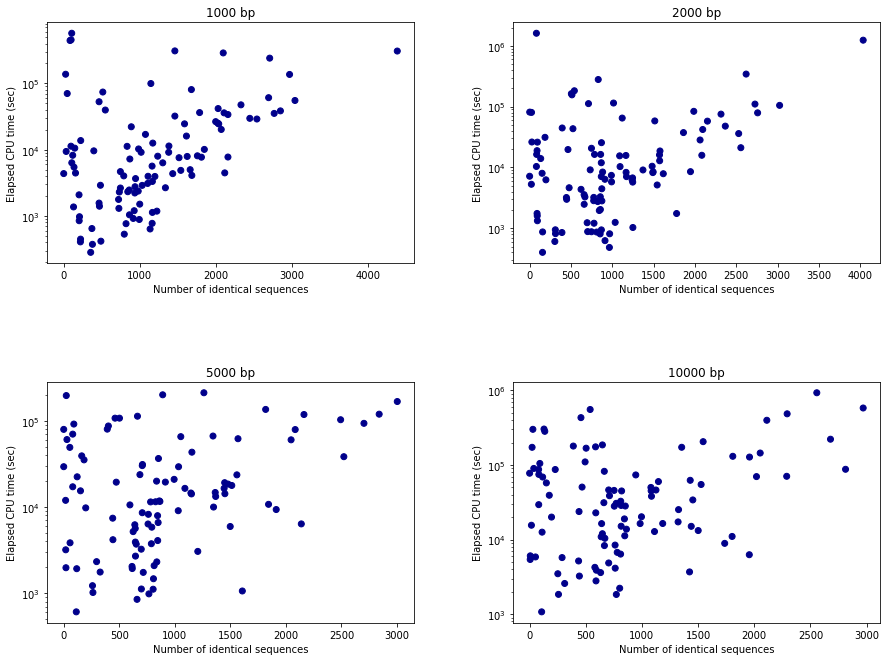

In [21]:
# Plot run times vs num identical sequences
import matplotlib
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from matplotlib.rcsetup import cycler
# cmap = ListedColormap(["darkblue","black","fuchsia","orange"])
# plt.rcParams['axes.prop_cycle'] = plt.cycler('color', cmap)
# plt.style.use('tableau-colorblind10')
import numpy as np
from math import log
method = "mstbackbone"

# Fixing random state for reproducibility

fig, ax = plt.subplots(2,2)
i = 0
# seq_len = 1000

# method_list = ['fasttree', 'mstbackbone']
# method_list = ['raxmlng','iqtree','fasttree','mstbackbone']
# method_list = ['mstbackbone','fasttree','raxmlng','iqtree']
# method_colors = {}
       

for seq_len in seqlen_list:
    method_colors = ["darkblue"] * len(dupl_seq_seq_len_method[seq_len][method])
    # if method == 'fasttree':
    if seq_len == 1000:
        # ax_fast.subplot(2, 2, i)    
        ax[0, 0].scatter(dupl_seq_seq_len_method[seq_len][method],run_times_seq_len_method[seq_len][method],label=method,c=method_colors)
        ax[0, 0].set_title(str(seq_len) + " bp")
        ax[0, 0].set_xlabel("Number of identical sequences")
        ax[0, 0].set_ylabel("Elapsed CPU time (sec)")
        # ax[0, 0].set_xscale("log")
        ax[0, 0].set_yscale("log")
    # elif method == 'mstbackbone':
    elif seq_len == 2000:
        # ax_mstbackbone.subplot(2, 2, i)    
        ax[0, 1].scatter(dupl_seq_seq_len_method[seq_len][method],run_times_seq_len_method[seq_len][method],label=method,c=method_colors)            
        ax[0, 1].set_title(str(seq_len) + " bp")
        ax[0, 1].set_xlabel("Number of identical sequences")
        ax[0, 1].set_ylabel("Elapsed CPU time (sec)")
        # ax[0, 1].set_xscale("log")
        ax[0, 1].set_yscale("log")
    # elif method == 'raxmlng':
    elif seq_len == 5000:
        # ax_raxml.subplot(2, 2, i)    
        ax[1, 0].scatter(dupl_seq_seq_len_method[seq_len][method],run_times_seq_len_method[seq_len][method],label=method,c=method_colors)
        ax[1, 0].set_title(str(seq_len) + " bp")
        ax[1, 0].set_xlabel("Number of identical sequences")
        ax[1, 0].set_ylabel("Elapsed CPU time (sec)")
        # ax[1, 0].set_xscale("log")
        ax[1, 0].set_yscale("log")
    # elif method == 'iqtree':
    elif seq_len == 10000:
        # ax_iqtree.plot(2, 2, i) 
        ax[1, 1].scatter(dupl_seq_seq_len_method[seq_len][method],run_times_seq_len_method[seq_len][method],label=method,c=method_colors)
        ax[1, 1].set_title(str(seq_len) + " bp")
        ax[1, 1].set_xlabel("Number of identical sequences")
        ax[1, 1].set_ylabel("Elapsed CPU time (sec)")
        # ax[1, 1].set_xscale("log")
        ax[1, 1].set_yscale("log")
# ax.set_yscale("log")
figures_path = projectPath + "figures/"
fig.tight_layout(pad=0.04)
# plt.legend(['MST-backbone (SEM-GMM)','FastTree 2','RAxML-NG', 'IQ-TREE 2'], bbox_to_anchor=(1.6,2.2), loc ="lower right", frameon=False)
fig.set_size_inches(13, 10)
plt.savefig(figures_path+"grove_scalability_mstb_dupl_seq.eps", dpi=100,bbox_inches='tight')
plt.savefig(figures_path+"grove_scalability_mstb_dupl_seq.png", dpi=100,bbox_inches='tight')
# plt.show()
# plt.show()

In [ ]:
# Store (Precision, Recall, RF) x (Rooted, Unrooted) x (FastTree, MST-backbone, RAxML-NG, IQ-TREE) x (1000, 2000, 5000, 10000)
recall_rooted_seq_len_method = {}
recall_unrooted_seq_len_method = {}
num_leaves_seq_len_method = {}
tree_id_seq_len_method = {}
accuracy_seq_len_method = {}
for seq_len in seqlen_list:
    recall_unrooted_seq_len_method[seq_len] = {}    
    recall_rooted_seq_len_method[seq_len] = {}
    num_leaves_seq_len_method[seq_len] = {}
    accuracy_seq_len_method[seq_len] = {}
    tree_id_seq_len_method[seq_len] = {}    
    for method in method_list:
        recall_unrooted_seq_len_method[seq_len][method] = []
        recall_rooted_seq_len_method[seq_len][method] = []
        num_leaves_seq_len_method[seq_len][method] = []
        accuracy_seq_len_method[seq_len][method] = []
        tree_id_seq_len_method[seq_len][method] = []


        
results_path = projectPath + "results/"
data_path = projectPath + "data/"

accuracy_grove_file = open(results_path + "grove_accuracy_oct_12","r")
accuracy_grove_file.readline()
for res in accuracy_grove_file:
    acc = res.split(",")
    pr_unrooted, re_unrooted, rf_unrooted, pr_rooted, re_rooted, rf_rooted, method, tree_id, seq_len, num_leaves = acc
    seq_len = int(seq_len.strip())
    num_leaves = int(num_leaves.strip())    
    accuracy_seq_len_method[seq_len][method].append([pr_unrooted, re_unrooted, rf_unrooted, pr_rooted, re_rooted, rf_rooted])
    recall_unrooted_seq_len_method[seq_len][method].append(float(re_unrooted))
    recall_rooted_seq_len_method[seq_len][method].append(float(re_rooted))
    num_leaves_seq_len_method[seq_len][method].append(int(num_leaves))
    tree_id_seq_len_method[seq_len][method].append(tree_id)


accuracy_grove_file.close()

from metrics import ComputePrecisionRecallAndRFGivenSplits, ComputePrecisionRecallAndRFforNonTrivialClusters, ComputePrecisionRecallAndRFforRootedTrees
from fileIO import ReadTree
data_path = projectPath + "data/"

def Get_accuracy(method,exp_id):    
    pr_rooted, re_rooted, rf_rooted = -1, -1, -1
    pr_unrooted, re_unrooted, rf_unrooted = -1, -1, -1
    tree_id = exp_id.split('_numLeaves_')[0].split('treeId_')[1]
    model_tree_file_name = data_path + 'RAxMLGrove/trees/' + tree_id + '/tree_best.newick'
    RT_model = ReadRootedTree(model_tree_file_name,"newick")
    splits_model = RT_model.GetAllNonTrivialSplits()
    if method == "raxmlng":
        tree_type = "unrooted"
        estimated_tree_file_name = projectPath + 'batch_scripts/RAxMLNG_' + exp_id + '.raxml.bestTree' 
    elif method == "fasttree":
        tree_type = "unrooted"
        estimated_tree_file_name = data_path + 'grove_exp/' + exp_id + '/sequences_' + exp_id + '.fas.fasttree_newick'       
    elif method == "mstbackbone":
        tree_type = "rooted"
        estimated_tree_file_name = data_path + 'grove_exp/' + exp_id + '/' + exp_id + '.newick'
    elif method == "iqtree":
        tree_type = "rooted"
        estimated_tree_file_name = data_path + 'grove_exp/' + exp_id + '/sequences_' + exp_id + '.fas_iqtree2.0.treefile'
    if tree_type == "rooted":
        RT_estimated = ReadRootedTree(estimated_tree_file_name, 'newick')
        pr_rooted, re_rooted, rf_rooted = ComputePrecisionRecallAndRFforRootedTrees(RT_model, RT_estimated)       
    elif tree_type == "unrooted":
        T_estimated = ReadTree(estimated_tree_file_name, 'newick')
        u_name, v_name = list(T_estimated.edgeLengths.keys())[0]
        t = T_estimated.GetEdgeLength(u_name, v_name)
        RT_estimated = T_estimated.GetRootedTree(u_name, v_name, t/2.0, t/2.0)    
    splits_estimated = RT_estimated.GetAllNonTrivialSplits()
    pr_unrooted, re_unrooted, rf_unrooted = ComputePrecisionRecallAndRFGivenSplits(splits_model, splits_estimated)
    return ([pr_unrooted, re_unrooted, rf_unrooted, pr_rooted, re_rooted, rf_rooted])

method_list = ['fasttree','iqtree','mstbackbone','raxmlng']
seqlen_list = [1000,2000,5000,10000]
num_leaves_list = []
accuracy_grove_file = open(results_path + "grove_accuracy_updated","w")
accuracy_grove_file.write("pr_unrooted, re_unrooted, rf_unrooted, pr_rooted, re_rooted, rf_rooted, method, tree_id, seq_len, num_leaves\n")
tree_id_num_leaves_scalability_file = open(data_path + "selected_grove_tree_ids_scalability","r")
num_trees_processed = 0
for line in tree_id_num_leaves_scalability_file:
    tree_id = line.strip().split(',')[0].strip()
    num_leaves = int(line.strip().split(',')[1].strip())
    for seq_len in seqlen_list:
        for method in method_list:
            exp_id = "treeId_" + tree_id + "_numLeaves_" + str(num_leaves) + "_seqLen_" + str(seq_len)
            if tree_id in tree_id_seq_len_method[seq_len][method]:
                tree_ind = tree_id_seq_len_method[seq_len][method].index(tree_id)
                accuracy = accuracy_seq_len_method[seq_len][method][tree_ind]
                # print("accuracy is ", accuracy)
                for acc in accuracy:
                    accuracy_grove_file.write(str(acc) + ",")
                accuracy_grove_file.write(method + "," + str(tree_id) + "," + str(seq_len) + "," + str(num_leaves) + "\n")
            else:
                if Check_results_file_names(method,exp_id):
                    accuracy = Get_accuracy(method,exp_id)
                    accuracy_seq_len_method[seq_len][method].append(accuracy)
                    for acc in accuracy:
                        accuracy_grove_file.write(str(acc) + ",")
                    num_leaves_seq_len_method[seq_len][method].append(num_leaves)
                    tree_id_seq_len_method[seq_len][method].append(tree_id)
                    accuracy_grove_file.write(method + "," + str(tree_id) + "," + str(seq_len) + "," + str(num_leaves) + "\n")
            print (tree_id)
    num_trees_processed += 1
    print("Finished computing accuracy for ", num_trees_processed, " trees")



accuracy_grove_file.close()
tree_id_num_leaves_scalability_file.close()

In [ ]:
# Write accuracy to file
results_path = projectPath + "results/"
data_path = projectPath + "data/"
accuracy_grove_file = open(results_path + "grove_accuracy","w")
accuracy_grove_file.write("pr_unrooted, re_unrooted, rf_unrooted, pr_rooted, re_rooted, rf_rooted, method, tree_id, seq_len, num_leaves\n")
method_list = ['fasttree','iqtree','mstbackbone','raxmlng']
seqlen_list = [1000,2000,5000,10000]
for seq_len in seqlen_list:
    for method in method_list:
        num_results = len(accuracy_seq_len_method[seq_len][method])
        for i in range(num_results):
            for acc in accuracy_seq_len_method[seq_len][method][i]:
                accuracy_grove_file.write(str(acc) + ",")            
            num_leaves = num_leaves_seq_len_method[seq_len][method][i]
            tree_id = tree_id_seq_len_method[seq_len][method][i]
            accuracy_grove_file.write(method + "," + str(tree_id) + "," + str(seq_len) + ", " + str(num_leaves) + "\n")






accuracy_grove_file.close()


In [5]:
# Read accuracy from file
recall_rooted_seq_len_method = {}
recall_unrooted_seq_len_method = {}
num_leaves_seq_len_method = {}
tree_id_seq_len_method = {}
for seq_len in seqlen_list:
    recall_unrooted_seq_len_method[seq_len] = {}
    recall_rooted_seq_len_method[seq_len] = {}
    num_leaves_seq_len_method[seq_len] = {}
    tree_id_seq_len_method[seq_len] = {}
    for method in method_list:
        recall_unrooted_seq_len_method[seq_len][method] = []
        recall_rooted_seq_len_method[seq_len][method] = []
        num_leaves_seq_len_method[seq_len][method] = []
        tree_id_seq_len_method[seq_len][method] = []



        
results_path = projectPath + "results/"
data_path = projectPath + "data/"

accuracy_grove_file = open(results_path + "grove_accuracy_oct_17","r")
accuracy_grove_file.readline()
for res in accuracy_grove_file:
    pr_unrooted, re_unrooted, rf_unrooted, pr_rooted, re_rooted, rf_rooted, method, tree_id, seq_len, num_leaves = res.split(",")    
    seq_len = int(seq_len)
    num_leaves = int(num_leaves)    
    recall_unrooted_seq_len_method[seq_len][method].append(float(re_unrooted))
    recall_rooted_seq_len_method[seq_len][method].append(float(re_rooted))
    num_leaves_seq_len_method[seq_len][method].append(int(num_leaves))
    tree_id_seq_len_method[seq_len][method].append(tree_id)


accuracy_grove_file.close()


In [ ]:
results_path = projectPath + "results/"
data_path = projectPath + "data/"
import pandas as pd
accuracy_grove = pd.read_csv(results_path + "grove_accuracy_oct_12")
accuracy_grove.rename(columns=lambda x: x.strip(),inplace=True)

# print(accuracy_grove.keys())
accuracy_seq_len = accuracy_grove[accuracy_grove["seq_len"] == 1000]
print(accuracy_seq_len[accuracy_seq_len['method'] == 'fasttree']['re_unrooted'])
print(accuracy_seq_len[accuracy_seq_len['method'] == 'fasttree']['tree_id'])
print(accuracy_seq_len[accuracy_seq_len['method'] == 'fasttree']['seq_len'])
# recall_unrooted_seq_len_method[seq_len]

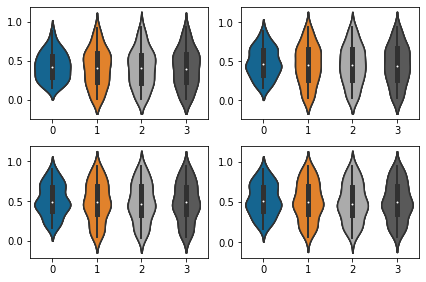

In [7]:
# Violin plots of accuracy
import matplotlib.pyplot as plt
import seaborn as sb
plt.style.use('tableau-colorblind10')
import numpy as np
from math import log

import pandas as pd
accuracy_grove = pd.read_csv(results_path + "grove_accuracy_oct_12")
accuracy_grove.rename(columns=lambda x: x.strip(),inplace=True)
#TODO add sequence length, change colors, 

fig, ax = plt.subplots(2,2)
i = 0
seq_len = 1000
pos_method = {}
method_list = ['mstbackbone','fasttree','raxmlng','iqtree']
# pos_method['mstbackbone'] = 1 
# pos_method['fasttree'] = 2
# pos_method['raxmlng'] = 3
# pos_method['iqtree'] = 4
pos = [1,2,3,4]
seqlen_list = [1000,2000,5000,10000]
recall_unrooted_list = {}
for seq_len in seqlen_list: 
    accuracy_seq_len = accuracy_grove[accuracy_grove["seq_len"] == seq_len]           
    recall_unrooted_list[seq_len] = []
    for method in method_list:
        recall_unrooted_list[seq_len].append(accuracy_seq_len[accuracy_seq_len['method'] == method]['re_unrooted'])

for seq_len in seqlen_list: 
    accuracy_seq_len = accuracy_grove[accuracy_grove["seq_len"] == seq_len]           
    for method in method_list:
        if seq_len == 1000:
            # ax[0, 0].violinplot(recall_unrooted_list[seq_len], pos)
            sb.violinplot(data=recall_unrooted_list[seq_len],ax=ax[0,0])
            # ax[0, 0].set_title(seq_len)
            # ax[0, 0].set_yscale("log")
        elif seq_len == 2000:
            sb.violinplot(data=recall_unrooted_list[seq_len],ax=ax[0,1])
            # ax[0, 1].violinplot(recall_unrooted_list[seq_len], pos)
            # ax[0, 1].set_title(seq_len)
            # ax[0, 1].set_yscale("log")
        elif seq_len == 5000:
            sb.violinplot(data=recall_unrooted_list[seq_len],ax=ax[1,0])
            # ax[1, 0].violinplot(recall_unrooted_list[seq_len], pos)
            # ax[1, 0].set_xticks([1,2,3,4],labels=['MST-backbone', 'FastTree', 'RAxML-NG', 'IQ-Tree'])
            # ax[1, 0].set_yscale("log")
        elif seq_len == 10000:
            sb.violinplot(data=recall_unrooted_list[seq_len],ax=ax[1,1])
            # ax[1, 1].violinplot(recall_unrooted_list[seq_len], pos)
            # ax[1, 1].set_title(seq_len)
            # ax[1, 1].set_yscale("log")
fig.tight_layout(pad=1.0)
# labels = ['A', 'B', 'C', 'D']
# plt.legend(method_list, loc ="upper right")
# plt.xlabel(method_list)
plt.show()

{1000: {'mstbackbone': 75, 'fasttree': 17, 'raxmlng': 7, 'iqtree': 9}, 2000: {'mstbackbone': 55, 'fasttree': 25, 'raxmlng': 10, 'iqtree': 12}, 5000: {'mstbackbone': 50, 'fasttree': 36, 'raxmlng': 9, 'iqtree': 8}, 10000: {'mstbackbone': 41, 'fasttree': 35, 'raxmlng': 8, 'iqtree': 14}}
{1000: {'mstbackbone': 70, 'iqtree': 38}, 2000: {'mstbackbone': 54, 'iqtree': 48}, 5000: {'mstbackbone': 47, 'iqtree': 56}, 10000: {'mstbackbone': 36, 'iqtree': 62}}
0.3868725868725868 1000
0.3868725868725868 1000
0.3868725868725868 1000
0.2753675152384367 1000
0.2753675152384367 1000
0.2753675152384367 1000
0.3016660758596242 1000
0.3016660758596242 1000
0.3016660758596242 1000
0.416170903190914 1000
0.416170903190914 1000
0.416170903190914 1000
0.2921951219512195 1000
0.2921951219512195 1000
0.2921951219512195 1000
0.2721939773171685 1000
0.2721939773171685 1000
0.2721939773171685 1000
0.1482326111744583 1000
0.1482326111744583 1000
0.1482326111744583 1000
0.352549889135255 1000
0.352549889135255 1000
0.

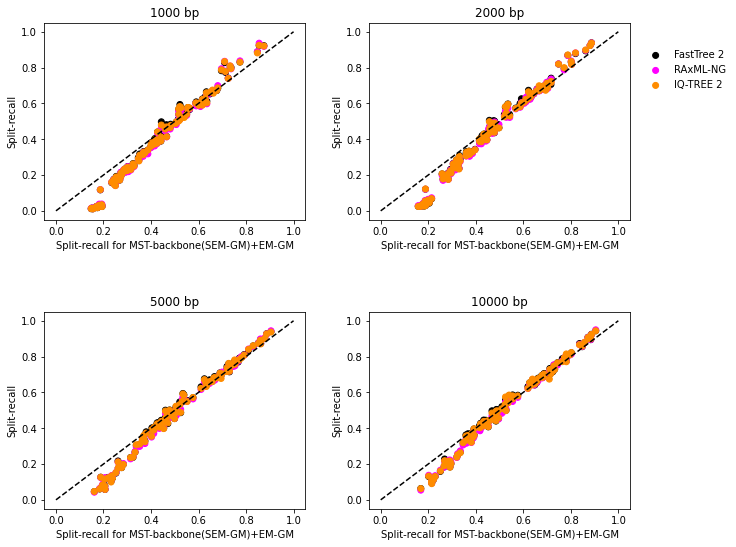

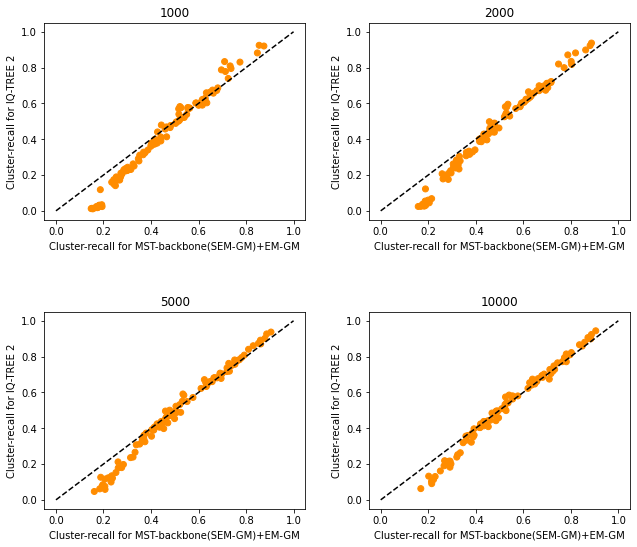

In [6]:
# Recall scatter plot against mst-backbone 
# from re import M
import matplotlib.pyplot as plt
import seaborn as sb
plt.style.use('tableau-colorblind10')
import numpy as np
from math import log

results_path = projectPath + "results/"
data_path = projectPath + "data/"
import pandas as pd
accuracy_grove = pd.read_csv(results_path + "grove_accuracy_oct_17")
accuracy_grove.rename(columns=lambda x: x.strip(),inplace=True)

# print(accuracy_grove.keys())
# accuracy_seq_len = accuracy_grove[accuracy_grove["seq_len"] == 1000]
# accuracy_seq_len_mstbackbone = accuracy_seq_len[accuracy_seq_len['method'] == 'mstbackbone']
# accuracy_seq_len_mstbackbone['tree_id'][accuracy_seq_len_mstbackbone.index(tree_id)]
# print(accuracy_seq_len[accuracy_seq_len['method'] == 'fasttree']['re_unrooted'])
# print(accuracy_seq_len[accuracy_seq_len['method'] == 'fasttree']['tree_id'])
# print(accuracy_seq_len[accuracy_seq_len['method'] == 'fasttree']['seq_len'])

from collections import Counter
recall_unrooted_rank_all = {}
recall_rooted_rank_all = {}
recall_unrooted_common_seq_len_method = {}
recall_rooted_common_seq_len_method = {}
# recall_wrt_mstbackbone = {}
for seq_len in seqlen_list:
    recall_unrooted_common_seq_len_method[seq_len] = {}
    recall_rooted_common_seq_len_method[seq_len] = {}
    # recall_wrt_mstbackbone[seq_len] = {}
    for method in method_list:
        recall_unrooted_common_seq_len_method[seq_len][method] = []
        recall_rooted_common_seq_len_method[seq_len][method] = []
        # recall_wrt_mstbackbone[seq_len][method] = []    

for seq_len in seqlen_list:
    recall_unrooted_rank_all[seq_len] = []
    recall_rooted_rank_all[seq_len] = []
    tree_id_common = set([])
    accuracy_seq_len = accuracy_grove[accuracy_grove['seq_len'] == seq_len]
    accuracy_seq_len_mstbackbone = accuracy_seq_len[accuracy_seq_len['method'] == 'mstbackbone']
    tree_id_common = set(accuracy_seq_len_mstbackbone['tree_id'])
    for method in method_list[1:]:
        accuracy_seq_len_method = accuracy_seq_len[accuracy_seq_len['method'] == method]
        tree_id_common = tree_id_common.intersection(set(accuracy_seq_len_method['tree_id']))
    tree_id_common_list = [int(x) for x in list(tree_id_common)]
    # print(len(tree_id_common_list)," results in common for seq len ", seq_len)
    for tree_id in tree_id_common_list:
        recall_unrooted_method = []
        recall_rooted_method = []
        for method in method_list:
            accuracy_seq_len_method = accuracy_seq_len[accuracy_seq_len['method'] == method]
            tree_id_seq_len_method = [int(x) for x in list(accuracy_seq_len_method['tree_id'])]
            res_ind = tree_id_seq_len_method.index(tree_id)
            recall_unrooted_seq_len_method = list(accuracy_seq_len_method['re_unrooted'])
            recall_rooted_seq_len_method = list(accuracy_seq_len_method['re_rooted'])
            recall_unrooted = float(recall_unrooted_seq_len_method[res_ind])
            recall_rooted = float(recall_rooted_seq_len_method[res_ind])
            # recall_common_seq_len_method[seq_len][method].append()
            # assert(accuracy_seq_len_mstbackbone['tree_id'][res_ind] == tree_id)
            recall_unrooted_common_seq_len_method[seq_len][method].append(recall_unrooted)
            recall_rooted_common_seq_len_method[seq_len][method].append(recall_rooted)
            recall_unrooted_method.append((recall_unrooted,method))
            recall_rooted_method.append((recall_rooted,method))
        recall_unrooted_method.sort(key = lambda x: x[0],reverse=True)
        recall_rooted_method.sort(key = lambda x: x[0],reverse=True)
        method_unrooted_sorted = [x[1] for x in recall_unrooted_method]
        method_rooted_sorted = [x[1] for x in recall_rooted_method]
        # recall_sorted = [x[0] for x in recall_method]        
        # print("*********************************")
        for method in method_list:
            rank_unrooted = method_unrooted_sorted.index(method) + 1
            recall_unrooted_rank_all[seq_len].append(str(rank_unrooted) + "_" + method)
        for method in ["mstbackbone", "iqtree"]:
            rank_rooted = method_rooted_sorted.index(method) + 1
            recall_rooted_rank_all[seq_len].append(str(rank_rooted) + "_" + method)

first_rank_unrooted_count_seq_len_method = {}
first_rank_rooted_count_seq_len_method = {}
first_rank_unrooted_count_method = {m:[] for m in method_list}
first_rank_rooted_count_method = {m:[] for m in ["mstbackbone","iqtree"]}

for seq_len in seqlen_list:
    first_rank_unrooted_count_seq_len_method[seq_len] = {}
    first_rank_rooted_count_seq_len_method[seq_len] = {}
    total_first_rank_res = 0
    total_second_rank_res = 0
    for method in method_list:
        first_rank_method = str(1) + "_" + method
        second_rank_method = str(2) + "_" + method
        # first_rank_method_count = recall_rank_all[seq_len].count(first_rank_method)
        first_rank_unrooted_count_seq_len_method[seq_len][method] = recall_unrooted_rank_all[seq_len].count(first_rank_method)
        first_rank_unrooted_count_method[method].append(recall_unrooted_rank_all[seq_len].count(first_rank_method))
        total_first_rank_res += recall_unrooted_rank_all[seq_len].count(first_rank_method)
        total_second_rank_res += recall_unrooted_rank_all[seq_len].count(second_rank_method)    
    assert(total_first_rank_res == total_second_rank_res)
    for method in ["mstbackbone","iqtree"]:
        first_rank_method = str(1) + "_" + method        
        first_rank_rooted_count_method[method].append(recall_rooted_rank_all[seq_len].count(first_rank_method))    
        first_rank_rooted_count_seq_len_method[seq_len][method] = recall_rooted_rank_all[seq_len].count(first_rank_method)
    
    # recall_rank_all[seq_len]
    # print("Rankings for sequence length: ",seq_len)
    # print(Counter(i for i in recall_rank_all[seq_len]))
print(first_rank_unrooted_count_seq_len_method)    
print(first_rank_rooted_count_seq_len_method)
# fig = plt.figure(figsize = (10, 5))
method_colors_method_seq_len = []
# method_colors[method] = {}
# for seq_len in seqlen_list:  

for seq_len in seqlen_list:
    num_res = len(recall_unrooted_common_seq_len_method[seq_len]["mstbackbone"])
    for res_ind in range(num_res):
        mstbackbone_recall_unrooted = recall_unrooted_common_seq_len_method[seq_len]["mstbackbone"][res_ind]
        for method in method_list[1:]:            
            competing_recall_unrooted = recall_unrooted_common_seq_len_method[seq_len][method][res_ind]
            if mstbackbone_recall_unrooted > competing_recall_unrooted:
                print (mstbackbone_recall_unrooted, seq_len)

    recall_unrooted_common_seq_len_method[seq_len]["mstbackbone"] 


# Creating the scatter plot for split-recall

fig, ax = plt.subplots(2,2)
for seq_len in seqlen_list:
# accuracy_seq_len = accuracy_grove[accuracy_grove["seq_len"] == seq_len]               
    for method in method_list[1:]:        
        method_colors_method_seq_len = method_colors_map[method] * len(recall_unrooted_common_seq_len_method[seq_len][method])
        if seq_len == 1000:
            ax[0, 0].set_title(str(seq_len) + " bp")
            ax[0, 0].set_xlabel('Split-recall for MST-backbone(SEM-GM)+EM-GM')
            ax[0, 0].set_ylabel('Split-recall')
            # ax[0, 0].plot([0,1],[0,1],linestyle = "dashed")
            ax[0, 0].scatter(recall_unrooted_common_seq_len_method[seq_len]["mstbackbone"],recall_unrooted_common_seq_len_method[seq_len][method],c=method_colors_method_seq_len)                                    
            # sb.violinplot(data=recall_unrooted_list[seq_len],ax=ax[0,0])            
        elif seq_len == 2000:
            ax[0, 1].set_title(str(seq_len) + " bp")
            # if plot_scatter:
            # sb.violinplot(data=recall_unrooted_list[seq_len],ax=ax[0,1])
            # ax[0, 1].plot([0,1],[0,1],linestyle = "dashed")
            ax[0, 1].set_xlabel('Split-recall for MST-backbone(SEM-GM)+EM-GM')
            ax[0, 1].set_ylabel('Split-recall')
            ax[0, 1].scatter(recall_unrooted_common_seq_len_method[seq_len]["mstbackbone"],recall_unrooted_common_seq_len_method[seq_len][method],c=method_colors_method_seq_len)
            # elif plot_bar:
            #     ax[0, 1].bar(first_rank_count_seq_len_method[seq_len].keys(),first_rank_count_seq_len_method[seq_len].values(),color=['darkblue','black','fuchsia','darkorange'])
            # ax[0, 1].violinplot(recall_unrooted_list[seq_len], pos)            
            #     ax[0, 1].set_xticklabels([" "," ", " ", " "],rotation=0)
                # ax[0, 1].set_xticklabels(["MST-backbone(SEM-GM)","FastTree 2", "RAxML-NG", "IQ-TREE 2"],rotation=30)                
            # ax[0, 1].set_yscale("log")
        elif seq_len == 5000:
            ax[1, 0].set_title(str(seq_len) + " bp")
            # if plot_scatter:            
            ax[1, 0].set_xlabel('Split-recall for MST-backbone(SEM-GM)+EM-GM')
            ax[1, 0].set_ylabel('Split-recall')
            ax[1, 0].scatter(recall_unrooted_common_seq_len_method[seq_len]["mstbackbone"],recall_unrooted_common_seq_len_method[seq_len][method],c=method_colors_method_seq_len)
            # ax[1, 0].scatter(first_rank_count_seq_len_method[seq_len].keys(),first_rank_count_seq_len_method[seq_len].values(),color=['darkblue','black','fuchsia','darkorange'])
            # ax[1, 0].violinplot(recall_unrooted_list[seq_len], pos)
            # elif plot_bar:
            # ax[1, 0].bar(first_rank_count_seq_len_method[seq_len].keys(),first_rank_count_seq_len_method[seq_len].values(),color=['darkblue','black','fuchsia','darkorange'])
            # ax[1, 0].set_xticks([1,2,3,4],labels=['MST-backbone', 'FastTree', 'RAxML-NG', 'IQ-Tree'])            
            # ax[1, 0].set_xticklabels(["MST-backbone(SEM-GM)+EM-GM')","FastTree 2", "RAxML-NG", "IQ-TREE 2"],rotation=30)                
            # ax[1, 0].set_yscale("log")
        elif seq_len == 10000:
            ax[1, 1].set_title(str(seq_len) + " bp")
            ax[1, 1].scatter(recall_unrooted_common_seq_len_method[seq_len]["mstbackbone"],recall_unrooted_common_seq_len_method[seq_len][method],c=method_colors_method_seq_len)
            ax[1, 1].set_xlabel('Split-recall for MST-backbone(SEM-GM)+EM-GM')
            ax[1, 1].set_ylabel('Split-recall')    
    # sb.violinplot(data=recall_unrooted_list[seq_len],ax=ax[1,1])
            
fig.tight_layout(pad=-0.1)    
plt.legend(['FastTree 2','RAxML-NG', 'IQ-TREE 2'], bbox_to_anchor=(1.4,2.08), loc ="lower right", numpoints = 1, frameon=False)
ax[0, 0].plot([0,1],[0,1],linestyle = "dashed",c="black")
ax[0, 1].plot([0,1],[0,1],linestyle = "dashed",c="black")
ax[1, 0].plot([0,1],[0,1],linestyle = "dashed",c="black")
ax[1, 1].plot([0,1],[0,1],linestyle = "dashed",c="black")
fig.set_size_inches(9, 8)
plt.savefig(projectPath+"figures/grove_split_recall_wrt_mstbackbone.eps", dpi=200,bbox_inches='tight')
plt.savefig(projectPath+"figures/grove_split_recall_wrt_mstbackbone.png", dpi=200,bbox_inches='tight')
        
    # plt.show()
# for seq_len in seqlen_list:
#     # accuracy_seq_len = accuracy_grove[accuracy_grove["seq_len"] == seq_len]
#     # for method in method_list[1:]:
#     # method_colors_method_seq_len = method_colors_map[method] * len(recall_common_seq_len_method[seq_len][method])
#     if seq_len == 1000:
#         # ax[0, 0].bar(first_rank_count_seq_len_method[seq_len].keys(),first_rank_count_seq_len_method[seq_len].values(),color=['darkblue','black','fuchsia','darkorange'])
#         ax[0, 0].bar(seq_len_str,MST,color=['darkblue'])
#         ax[0, 0].bar(seq_len_str,FST,bottom=MST,color=['black'])
#         ax[0, 0].bar(seq_len_str,RxM,bottom=MST+FST,color=['fuchsia'])
#         ax[0, 0].bar(seq_len_str,IQT,bottom=MST+FST+RxM,color=['darkorange'])
#         # ax[0, 0].bar(first_rank_count_seq_len_method[seq_len].keys(),first_rank_count_seq_len_method[seq_len].values(),color=['black'])
#         # ax[0, 0].bar(first_rank_count_seq_len_method[seq_len].keys(),first_rank_count_seq_len_method[seq_len].values(),color=['fuchsia'])
#         # ax[0, 0].bar(first_rank_count_seq_len_method[seq_len].keys(),first_rank_count_seq_len_method[seq_len].values(),color=['darkorange'])
        
#         # ax[0, 0].set_xticklabels([" "," ", " ", " "],rotation=0)
#         # ax[0, 0].set_yscale('log')
#         ax[0, 0].legend(['MST-backbone(SEM-GM)', 'FastTree 2','RAxML-NG', 'IQ-TREE 2'], loc ="upper right", frameon=False)
#     elif seq_len == 2000:
#         ax[0, 1].bar(first_rank_count_seq_len_method[seq_len].keys(),first_rank_count_seq_len_method[seq_len].values(),color=['darkblue','black','fuchsia','darkorange'])
#         # ax[0, 1].set_xticklabels([" "," ", " ", " "],rotation=0)
#     elif seq_len == 5000:
#         ax[1, 0].set_title(seq_len)
#         ax[1, 0].bar(first_rank_count_seq_len_method[seq_len].keys(),first_rank_count_seq_len_method[seq_len].values(),color=['darkblue','black','fuchsia','darkorange'])
#         # ax[1, 0].set_xticks([1,2,3,4],labels=['MST-backbone', 'FastTree', 'RAxML-NG', 'IQ-Tree'])
#         # ax[1, 0].set_xticklabels(["MST-backbone(SEM-GM)+EM-GM')","FastTree 2", "RAxML-NG", "IQ-TREE 2"],rotation=30)
#     elif seq_len == 10000:
#         ax[1, 1].set_title(seq_len)
#         ax[1, 1].bar(first_rank_count_seq_len_method[seq_len].keys(),first_rank_count_seq_len_method[seq_len].values(),color=['darkblue','black','fuchsia','darkorange'])
#             # ax[1, 1].set_xticklabels(["MST-backbone(SEM-GM)+EM-GM","FastTree 2", "RAxML-NG", "IQ-TREE 2"],rotation=30)
#             # sb.violinplot(data=recall_unrooted_list[seq_len],ax=ax[1,1])          
# fig.tight_layout(pad=-0.1)
    

# fig.set_size_inches(8, 8)
# plt.savefig(projectPath+"figures/grove_split_recall_barplot.eps", dpi=100,bbox_inches='tight')
# plt.savefig(projectPath+"figures/grove_split_recall_barplot.png", dpi=100,bbox_inches='tight')

# Cluster-recall

fig, ax = plt.subplots(2,2)

# fig = plt.figure(figsize = (10, 5))
method_colors_method_seq_len = []
# method_colors[method] = {}
# for seq_len in seqlen_list:  

plot_bar = False
plot_scatter = True

# creating the bar plot
method = "iqtree"
for seq_len in seqlen_list: 
    # accuracy_seq_len = accuracy_grove[accuracy_grove["seq_len"] == seq_len]                   
    method_colors_method_seq_len = method_colors_map[method] * len(recall_unrooted_common_seq_len_method[seq_len][method])
    if seq_len == 1000:
        ax[0, 0].set_title(seq_len)
        if plot_scatter:
            ax[0, 0].set_xlabel('Cluster-recall for MST-backbone(SEM-GM)+EM-GM')
            ax[0, 0].set_ylabel('Cluster-recall for IQ-TREE 2')
            # ax[0, 0].plot([0,1],[0,1],linestyle = "dashed")
            ax[0, 0].scatter(recall_unrooted_common_seq_len_method[seq_len]["mstbackbone"],recall_unrooted_common_seq_len_method[seq_len]["iqtree"],c=method_colors_method_seq_len)
            # ax[0, 0].legend(['MST-backbone (SEM-GMM)','FastTree 2','RAxML-NG', 'IQ-TREE 2'], loc ="upper right", frameon=False)
        elif plot_bar:
            ax[0, 0].bar(first_rank_unrooted_count_seq_len_method[seq_len].keys(),first_rank_unrooted_count_seq_len_method[seq_len].values(),color=['darkblue','black','fuchsia','darkorange'])
            # ax[0, 0].set_xticklabels([" "," ", " ", " "],rotation=0)            
            ax[0, 0].set_yscale("log")
        # sb.violinplot(data=recall_unrooted_list[seq_len],ax=ax[0,0])            
    elif seq_len == 2000:
        ax[0, 1].set_title(seq_len)
        if plot_scatter:
        # sb.violinplot(data=recall_unrooted_list[seq_len],ax=ax[0,1])            
            ax[0, 1].set_xlabel('Cluster-recall for MST-backbone(SEM-GM)+EM-GM')
            ax[0, 1].set_ylabel('Cluster-recall for IQ-TREE 2')
            ax[0, 1].scatter(recall_unrooted_common_seq_len_method[seq_len]["mstbackbone"],recall_unrooted_common_seq_len_method[seq_len][method],c=method_colors_method_seq_len)
        elif plot_bar:
            ax[0, 1].bar(first_rank_unrooted_count_seq_len_method[seq_len].keys(),first_rank_unrooted_count_seq_len_method[seq_len].values(),color=['darkblue','black','fuchsia','darkorange'])
        # ax[0, 1].violinplot(recall_unrooted_list[seq_len], pos)            
            # ax[0, 1].set_xticklabels([" "," ", " ", " "],rotation=0)
            # ax[0, 1].set_xticklabels(["MST-backbone(SEM-GM)","FastTree 2", "RAxML-NG", "IQ-TREE 2"],rotation=30)                
        # ax[0, 1].set_yscale("log")
    elif seq_len == 5000:
        ax[1, 0].set_title(seq_len)
        if plot_scatter:            
            ax[1, 0].set_xlabel('Cluster-recall for MST-backbone(SEM-GM)+EM-GM')
            ax[1, 0].set_ylabel('Cluster-recall for IQ-TREE 2')
            ax[1, 0].scatter(recall_unrooted_common_seq_len_method[seq_len]["mstbackbone"],recall_unrooted_common_seq_len_method[seq_len][method],c=method_colors_method_seq_len)
        # ax[1, 0].scatter(first_rank_count_seq_len_method[seq_len].keys(),first_rank_count_seq_len_method[seq_len].values(),color=['darkblue','black','fuchsia','darkorange'])
        # ax[1, 0].violinplot(recall_unrooted_list[seq_len], pos)
        elif plot_bar:
            ax[1, 0].bar(first_rank_unrooted_count_seq_len_method[seq_len].keys(),first_rank_unrooted_count_seq_len_method[seq_len].values(),color=['darkblue','black','fuchsia','darkorange'])
            # ax[1, 0].set_xticks([1,2,3,4],labels=['MST-backbone', 'FastTree', 'RAxML-NG', 'IQ-Tree'])            
            # ax[1, 0].set_xticklabels(["MST-backbone(SEM-GM)","FastTree 2", "RAxML-NG", "IQ-TREE 2"],rotation=30)                
            ax[1, 0].set_yscale("log")
    elif seq_len == 10000:
        ax[1, 1].set_title(seq_len)
        if plot_scatter:
            # ax[1, 1].plot([0,1],[0,1],linestyle = "dashed")
            ax[1, 1].scatter(recall_unrooted_common_seq_len_method[seq_len]["mstbackbone"],recall_unrooted_common_seq_len_method[seq_len][method],c=method_colors_method_seq_len)
            ax[1, 1].set_xlabel('Cluster-recall for MST-backbone(SEM-GM)+EM-GM')
            ax[1, 1].set_ylabel('Cluster-recall for IQ-TREE 2')
        elif plot_bar:
            ax[1, 1].bar(first_rank_unrooted_count_seq_len_method[seq_len].keys(),first_rank_unrooted_count_seq_len_method[seq_len].values(),color=['darkblue','black','fuchsia','darkorange'])
            # ax[1, 1].set_xticklabels(["MST-backbone(SEM-GM)+EM-GM","FastTree 2", "RAxML-NG", "IQ-TREE 2"],rotation=30)
            # sb.violinplot(data=recall_unrooted_list[seq_len],ax=ax[1,1])

fig.tight_layout(pad=-0.1)
# plt.legend(['MST-backbone (SEM-GMM)','FastTree 2','RAxML-NG', 'IQ-TREE 2'], bbox_to_anchor=(1.6,1.2), loc ="lower right", frameon=False)
if plot_scatter:
    # plt.legend(['IQ-TREE 2'], bbox_to_anchor=(1.4,2.08), loc ="lower right", numpoints = 1, frameon = False)
    ax[0, 0].plot([0,1],[0,1],linestyle = "dashed",c="black")
    ax[0, 1].plot([0,1],[0,1],linestyle = "dashed",c="black")
    ax[1, 0].plot([0,1],[0,1],linestyle = "dashed",c="black")
    ax[1, 1].plot([0,1],[0,1],linestyle = "dashed",c="black")
    fig.set_size_inches(9, 8)
    plt.savefig(projectPath+"figures/grove_cluster_recall_wrt_mstbackbone.eps", dpi=100,bbox_inches='tight')
    plt.savefig(projectPath+"figures/grove_cluster_recall_wrt_mstbackbone.png", dpi=100,bbox_inches='tight')
# plt.savefig(results_path+"grove_recall_split_barplot.eps", dpi=100,bbox_inches='tight')   
elif plot_bar:
    fig.set_size_inches(8, 8)
    plt.savefig(projectPath+"figures/grove_cluster_recall_barplot.eps", dpi=100,bbox_inches='tight')
    plt.savefig(projectPath+"figures/grove_cluser_recall_barplot.png", dpi=100,bbox_inches='tight')



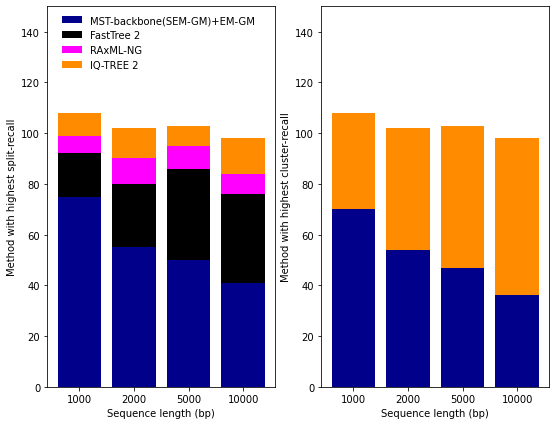

In [48]:
import numpy as np
seq_len_str = ['1000', '2000', '5000', '10000']
MST_u = np.array(first_rank_unrooted_count_method["mstbackbone"])
FST_u = np.array(first_rank_unrooted_count_method["fasttree"])
RxM_u = np.array(first_rank_unrooted_count_method["raxmlng"])
IQT_u = np.array(first_rank_unrooted_count_method["iqtree"])

MST_r = np.array(first_rank_rooted_count_method["mstbackbone"])
IQT_r = np.array(first_rank_rooted_count_method["iqtree"])
# print(MST)
# print(FST)
# print(RxM)
# print(IQT)

fig, ax = plt.subplots(1,2)

ax[0].bar(seq_len_str,MST_u,color=['darkblue'], label="MST-backbone(SEM-GM)+EM-GM")
ax[0].bar(seq_len_str,FST_u,bottom=MST_u,color=['black'], label="FastTree 2")
ax[0].bar(seq_len_str,RxM_u,bottom=MST_u+FST_u,color=['fuchsia'], label="RAxML-NG")
ax[0].bar(seq_len_str,IQT_u,bottom=MST_u+FST_u+RxM_u,color=['darkorange'], label="IQ-TREE 2")

ax[0].set_xlabel("Sequence length (bp)")
ax[0].set_ylabel("Method with highest split-recall")

ax[0].set_ylim(0,150)
ax[0].legend(frameon=False,bbox_to_anchor=(0.95,1))
ax[1].bar(seq_len_str,MST_r,color=['darkblue'], label="MST-backbone(SEM-GM)+EM-GM")
ax[1].bar(seq_len_str,IQT_r,bottom=MST_r,color=['darkorange'], label="IQ-TREE 2")

ax[1].set_xlabel("Sequence length (bp)")
ax[1].set_ylabel("Method with highest cluster-recall")
ax[1].set_ylim(0,150)
# plt.show()
# fig.tight_layout(pad=-0.5)
fig.set_size_inches(9, 7)

plt.savefig(projectPath+"figures/grove_cluster_recall_barplot.eps", dpi=100,bbox_inches='tight')
plt.savefig(projectPath+"figures/grove_cluster_recall_barplot.png", dpi=100,bbox_inches='tight')

In [15]:
# Cluster-recall IQ-TREE vs mst-backbone
method = "mstbackbone"
ind = recall_common_seq_len_method[10000][method].index(min(recall_common_seq_len_method[10000][method]))
print("min tree_id is ",tree_id_common_list[ind])
print ("min split-recall is ",recall_common_seq_len_method[10000]["mstbackbone"][ind])
print ("min split-recall is ",recall_common_seq_len_method[10000]["fasttree"][ind])
print ("min split-recall is ",recall_common_seq_len_method[10000]["raxmlng"][ind])
print ("min split-recall is ",recall_common_seq_len_method[10000]["iqtree"][ind])

min tree_id is  52785
min split-recall is  0.1687571265678449
min split-recall is  0.0632839224629418
min split-recall is  0.0541619156214367
min split-recall is  0.0627137970353477
